In [71]:
import networkx as nx
import numpy as np
import copy as cp

### Question 3

I chose to implement Google's PageRank centrality measure. 

All code is my own. I used https://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html as a reference.

In [2]:
'''
Inputs
------
G: Networkx graph
n: node for which to compute connectivity (if None, compute for all nodes), default: None
p: damping factor (p in range (0,1)), default: 0.15
max_iter: how many iterations before returning connectivity, default: 100

Outputs
-------
connectivity_dict: dictionary of nodes -> connectivity 
'''
def my_pagerank(G, n=None, p=0.15, max_iter=100):

    # if G is an undirected graph, convert it to a directed graph with 2 directed edges for each undirected edge
    if not nx.is_directed(G):
        G = G.to_directed()

    order = G.order()

    # create vector connectivity - initialize connectivities to all be the same (normalized {0, 1})
    connectivity = np.full((order,1), 1/order) 

    # create matrix A - transition matrix showing importance that each node gives to other nodes
    A = np.zeros((order, order))
    for node1 in range(order):
        for node2 in range(order):
            if node1 in list(G.neighbors(node2)):
                deg = G.out_degree[node2]
                A[node1][node2] = 1 / deg

    # create matrix B - initialized to initial connectivities
    B = np.full((order, order), 1 / order)
    
    # create matrix PR(A) - add in random "surfing" between nodes
    PRA = (1 - p) * A + p * B

    # multiply connectivities by PR(A) until convergence
    for i in range(max_iter):
        old_connectivity = cp.deepcopy(connectivity)
        connectivity = np.matmul(PRA, connectivity)

        # if we converge (to 6 decimal places), stop iterating
        if np.array_equal(np.around(connectivity, decimals=6), np.around(old_connectivity, decimals=6)):
            break
        
    connectivity_dict = {}
    for i, c in zip(range(order), connectivity):
        connectivity_dict[i] = c[0]

    if n != None:
        return connectivity_dict[n]
    return connectivity_dict
    

#### Error handling

My function handles cases where:
    - 
    -
    -
    -

In [ ]:
'''
Comparing my implementation
'''

### Question 4

All code is my own. I used https://networkx.org/ and https://pypi.org/project/beautifulsoup4/ as references.

In [6]:
from bs4 import BeautifulSoup
import requests
import networkx as nx
import copy as cp

#### a) Scraping a department's courses

All code is my own. I used https://networkx.org/ and https://pypi.org/project/beautifulsoup4/ as references.

In [11]:
'''
Get URL to department catalog from department code. If the code does not exist, raise an error. 

Inputs
------
dept_code: department code (codes can be found at https://catalog.northeastern.edu/course-descriptions/). Example: MATH for Mathematics.

Outputs
-------
url: url to the department course catalog
'''
def dept_code_to_url(dept_code: str) -> str:
    catalog_res = requests.get('https://catalog.northeastern.edu/course-descriptions/')
    catalog_html = catalog_res.text
    catalog_soup = BeautifulSoup(catalog_html)
    
    url = '/course-descriptions/' + dept_code + '/'
    if url in [x['href'] for x in catalog_soup.find_all('a', href=True)]:
        return 'https://catalog.northeastern.edu' + url
                
    raise ValueError('No department found with the code ' + dept_code)
            
'''
Create a mapping of all courses in a given department to their prerequisites. Return an empty dictionary if department does not exist. 

Inputs
------
dept_code: department code (codes can be found at https://catalog.northeastern.edu/course-descriptions/). Example: MATH for Mathematics.

Outputs
-------
courses_to_prereqs: dictionary with courses as keys and lists of prerequisites as values
'''
def get_prereqs(dept_code: str) -> list:
    try:
        href = dept_code_to_url(dept_code)
    except ValueError as e:
        return {}
    
    dept_res = requests.get(href)
    dept_html = dept_res.text
    dept_soup = BeautifulSoup(dept_html)

    courses_to_prereqs = {}

    course_descs_soup = dept_soup.find('div', attrs={'class' : 'sc_sccoursedescs'})
    
    for course in course_descs_soup.find_all('div', attrs={'class' : 'courseblock'}):
        course_code = course.find('p', attrs={'class' : 'courseblocktitle'}).text.split('.')[0].replace(u'\xa0', '')
        prereqs = []
        for extra in course.find_all('p', attrs={'class' : 'courseblockextra'}):
            if 'Prerequisite(s)' in extra.text:
                for link in extra.find_all('a', href=True):
                    prereqs.append(link.text.replace(u'\xa0', ''))
        courses_to_prereqs[course_code] = prereqs

    return courses_to_prereqs

#### b) Creating a DAG of a given curriculum

Note: I interpreted this question as creating a graph of the classes for a single department - the previous functions can be used to create a mapping of one department's courses and prerequisites. This function could just as easily be used to create a DAG of all classes in all departments by passing a combined dictionary of all department mappings. 

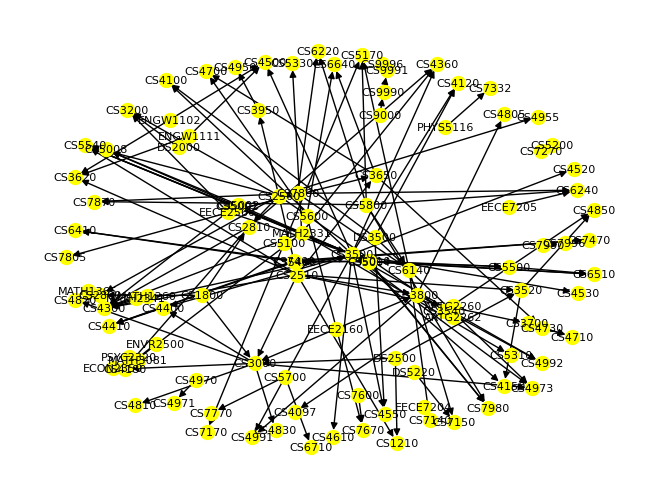

In [46]:
'''
Create a DAG from a given set of courses and their prerequisites.

Inputs
------
courses_to_prereqs: dictionary with courses as keys and lists of prerequisites as values

Outputs
-------
G: a DAG with a node for each course, and edges between courses that are prerequisites for other courses
'''
def course_prereqs(courses_to_prereqs: dict):
    G = nx.DiGraph()
    for k,v in courses_to_prereqs.items():
        edges = [(val,k) for val in v]
        G.add_edges_from(edges)
        
    return G

# example usage
nx.draw(course_prereqs(get_prereqs('cs')), with_labels=True, node_size=100, node_color='yellow', font_size=8)

#### c) Finding the department with the most prerequisites per course

Note: This metric is not perfect, as many of the prerequisites listed in the catalog have an 'OR' relationship. That means that the department output by the code below is the one with the most prerequisites listed, and not necessarily the department that requires the most actual prerequisites required in order to be able to take an average course. 

In [16]:
'''
Get all department codes.

Outputs
-------
codes: a list of all NEU department codes
'''
def get_dept_codes() -> list[str]:
    codes = []
    
    catalog_res = requests.get('https://catalog.northeastern.edu/course-descriptions/')
    catalog_html = catalog_res.text
    catalog_soup = BeautifulSoup(catalog_html)

    atoz_soup = catalog_soup.find('div', id='atozindex')
    dept_lists_soup = atoz_soup.find_all('ul')
    for l in dept_lists_soup:
        depts_soup = l.find_all('li')
        for li in depts_soup:
            codes.append(li.a.get('href').split('/')[-2])
            
    return codes

'''
Find the department with the most prerequisites per course. Skip departments that are not formatted in an expected manner.

Outputs
-------
max: the department code with the most prerequisties per course listed in the catalog
'''
def most_prereqs() -> str:
    avg_prereqs = {}

    for code in get_dept_codes():
        try:
            courses_to_prereqs = get_prereqs(code)
            count_prs = 0
            for _, prs in courses_to_prereqs.items():
                count_prs += len(prs)
            avg = count_prs / len(courses_to_prereqs)
            avg_prereqs[code] = avg
        except:
            continue


    return max(avg_prereqs, key= lambda x: avg_prereqs[x])

print('Department with the most prerequisites per course: ' + str(most_prereqs()))

Department with the most prerequisites per course: anth


#### d) Finding the longest chain of prerequisites

In [17]:
'''
Find the longest chain of prerequisites from all departments. Skip departments that are not formatted in an expected manner.

Outputs
-------
max_chain: a list containing the longest chain of courses found among all departments.
'''
def longest_chain() -> list:
    max_chain = []

    for code in get_dept_codes():
        try:
            courses_to_prereqs = get_prereqs(code)
            G = course_prereqs(courses_to_prereqs)
            longest_path = nx.dag_longest_path(G)
            if len(longest_path) > len(max_chain):
                max_chain = cp.deepcopy(longest_path)
        except Exception as e:
            continue

    return max_chain

print('Longest chain of prerequisites: ' + str(longest_chain()))

Longest chain of prerequisites: ['PT6330', 'PT6340', 'PT5138', 'PT5150', 'PT5540', 'PT5505', 'PT5230', 'PT6441', 'PT6442', 'PT6448']


### Question 5

All code is my own. 

#### a) Describing the network

I chose the BARACKOBAMA Twitter (https://networkrepository.com/rt-barackobama.php) dataset. The dataset was created by scraping data from Twitter. The network is a collection of Twitter accounts (nodes) and retweets (edges). The retweets were collected by finding tweets that contain certain hashtags - presumably hashtags that mention Barack Obama. 

#### b) Comparing to a randomized network

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

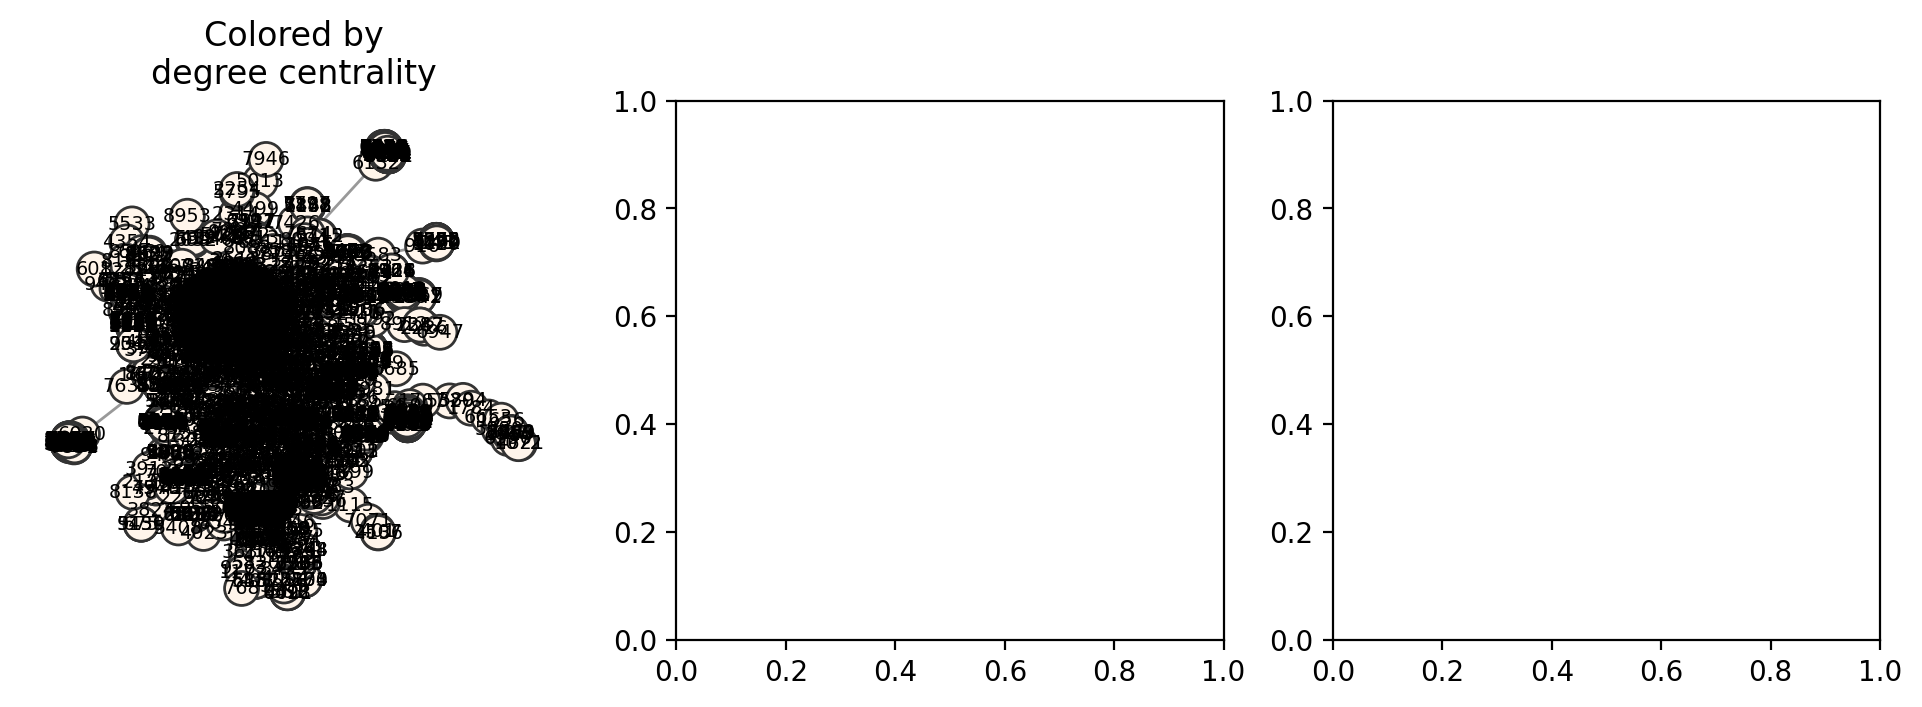

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

G = nx.read_edgelist('../rt_barackobama.edges', delimiter=',')

pos = nx.spring_layout(G)

fig, ax = plt.subplots(1,3,figsize=(12,3.5),dpi=200)

col_map = {0:plt.cm.Oranges,
           1:plt.cm.Blues,
           2:plt.cm.Greens}
cent_labels = ['degree centrality',
               'eigenvector centrality',
               'closeness centrality']

for i,centrality in enumerate([nx.degree, nx.eigenvector_centrality, nx.closeness_centrality]):
    cents = dict(centrality(G))
    cent_vals = list(cents.values())
    cent_vals_minmax = (np.array(cent_vals)-min(cent_vals))/(max(cent_vals)-min(cent_vals))
    ncs = col_map[i](cent_vals_minmax)
    nx.draw(G, pos, node_size=150, node_color=ncs, edgecolors='.2',
            with_labels=True, font_size='x-small', edge_color='.6', ax=ax[i])
    ax[i].set_title("Colored by\n"+cent_labels[i])


plt.savefig('images/pngs/centrality_compare_networkx.png', dpi=425, bbox_inches='tight')
plt.savefig('images/pdfs/centrality_compare_networkx.pdf', bbox_inches='tight')

plt.show()

#null_model = nx.double_edge_swap(G, nswap=G.number_of_edges(), max_tries=100000)



